In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

2024-09-14 14:42:43.109390: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-14 14:42:43.127738: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-14 14:42:43.133310: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-14 14:42:43.146965: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-14 14:42:44.121461: W tensorflow/compiler/tf2

In [2]:
# Load and preprocess data
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path, header=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], index_col=0)

    df.columns = [
        "district",
        "market",
        "commodity",
        "variety",
        "grade",
        "min_price",
        "max_price",
        "modal_price",
        "date",
    ]
    df["date"] = pd.to_datetime(df["date"], format="%d %b %Y")
    df = df.sort_values("date")
    return df[["date", "modal_price"]]

In [4]:
df1 = load_and_preprocess_data("response_01_Sep_2014_to_01_Sep_2015.csv")
df2 = load_and_preprocess_data("response_01_Sep_2015_to_01_Sep_2016.csv")

df3 = load_and_preprocess_data("response_01_Sep_2016_to_01_Sep_2017.csv")
df4 = load_and_preprocess_data("response_01_Sep_2017_to_01_Sep_2018.csv")
df5 = load_and_preprocess_data("response_01_Sep_2018_to_01_Sep_2019.csv")

# Combine datasets
df = pd.concat([df1, df2, df3, df4, df5]).sort_values("date")

df = df.groupby(['date'])['modal_price'].agg("mean").reset_index()

# # Normalize data
scaler = MinMaxScaler()
df["modal_price_scaled"] = scaler.fit_transform(df[["modal_price"]])

In [5]:
df.head()

,date,modal_price,modal_price_scaled
0,2014-09-01,2000.0,0.449351
1,2014-09-02,1665.0,0.362338
2,2014-09-03,1697.5,0.370779
3,2014-09-04,1790.0,0.394805
4,2014-09-05,1750.0,0.384416


<Axes: >

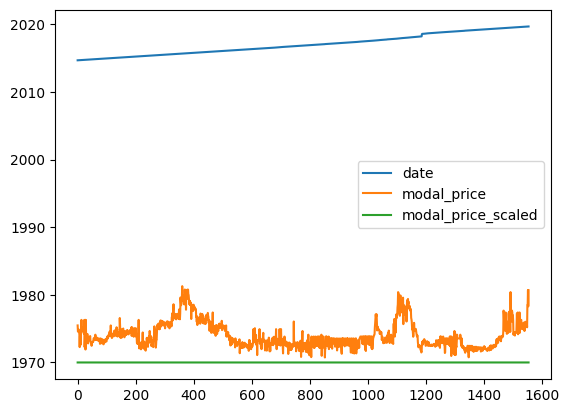

In [6]:
df.plot()

In [7]:
# Prepare data for time series prediction
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : (i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [8]:
seq_length = 10
X, y = create_sequences(df["modal_price_scaled"].values, seq_length)

# Split data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for LSTM and GRU
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# LSTM Model
lstm_model = Sequential(
    [Input(shape=(seq_length, 1)), LSTM(50, activation="relu"), Dense(1)]
)
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
lstm_model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, verbose=0)

criterion = torch.nn.MSELoss()

lstm_pred = lstm_model.predict(X_test_reshaped)

lstm_pred = scaler.inverse_transform(lstm_pred)

y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [9]:
# Calculate metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # For F1 score, we need to convert regression to classification
    # Let's consider a prediction correct if it's within 5% of the true value
    y_true_class = (y_true >= np.median(y_true)).astype(int)
    y_pred_class = (y_pred >= np.median(y_pred)).astype(int)
    f1 = f1_score(y_true_class, y_pred_class)

    return mse, mae, rmse, f1, r2

In [10]:

lstm_metrics = calculate_metrics(y_test_original, lstm_pred)

print("LSTM Metrics (MSE, MAE, RMSE, F1,R2):", lstm_metrics)

LSTM Metrics (MSE, MAE, RMSE, F1,R2): (90561.08770821568, 200.46197746795357, 300.9336932086796, 0.8838709677419355, 0.7993611232456621)
